In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing all the required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import IPython.display as ipd

In [6]:
from torchvision import transforms
from tqdm import tqdm

In [7]:
import glob
from PIL import Image

In [8]:
visual_images_path = '/content/visual_frames_final'
all_image_files = sorted(glob.glob('/content/visual_frames_final/*/*.jpg'))

In [9]:
all_audio_files = sorted(glob.glob('/content/Audio*/*/*.wav'))

In [10]:
len(all_audio_files), len(all_image_files)

(2496, 62042)

In [11]:
label_to_emotion = {'01':'neutral', 
                    '02': 'calm', 
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fearful',
                    '07': 'disgust',
                    '08': 'surprised'}

In [12]:
FILES = {'filepath':[], 
         'label':[], 
         'emotion': [],
         'actor':[], 
         'intensity': [], 
         'duration': [],
         'image_paths': []}
want_duration = False
for wav_file in tqdm(all_audio_files):
  filename = wav_file.replace('.wav', '')
  label = os.path.basename(filename).split('-')[2]
  intensity = os.path.basename(filename).split('-')[3]
  actor = os.path.basename(filename).split('-')[-1]
  
  # filling the dictionary
  FILES['filepath'].append(wav_file)
  FILES['label'].append(label)
  FILES['emotion'].append(label_to_emotion[label])
  FILES['actor'].append(actor)
  FILES['intensity'].append(intensity)
  if want_duration:
    FILES['duration'].append(librosa.get_duration(filename=wav_file))
  else:
    FILES['duration'].append(0.0)
  
  # for video face extraction
  video_file = wav_file
  vid_tag = "=".join(video_file.split('/')[-2:]).replace('.wav', '')
  label = os.path.basename(video_file).split('-')[2]
  label_dir = os.path.join(visual_images_path, label)

  savepath = os.path.join(label_dir, f'{vid_tag}=*.jpg').replace('=03-', '=01-')
  imgpaths = sorted(glob.glob(savepath)) or 'NAH'

  FILES['image_paths'].append(imgpaths)


100%|██████████| 2496/2496 [00:25<00:00, 98.33it/s] 


In [13]:
df = pd.DataFrame(FILES)
df

,filepath,label,emotion,actor,intensity,duration,image_paths
0,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
1,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
2,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
3,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,01,neutral,01,01,0.0,[/content/visual_frames_final/01/Actor_01=01-0...
4,/content/Audio_Songs_Actors_01-24/Actor_01/03-...,02,calm,01,01,0.0,[/content/visual_frames_final/02/Actor_01=01-0...
...,...,...,...,...,...,...,...
2491,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,01,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2492,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2493,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...
2494,/content/Audio_Speech_Actors_01-24/Actor_24/03...,08,surprised,24,02,0.0,[/content/visual_frames_final/08/Actor_24=01-0...


In [14]:
# df.iloc[0].image_paths

In [15]:
from collections import Counter

Counter(df.emotion)

Counter({'angry': 384,
         'calm': 384,
         'disgust': 192,
         'fearful': 384,
         'happy': 384,
         'neutral': 192,
         'sad': 384,
         'surprised': 192})

In [16]:
# to split the data into training and validation
from sklearn.model_selection import train_test_split

In [17]:
train_df, dev_df = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.15, random_state=6)
dev_df, test_df = train_test_split(dev_df, shuffle=True, stratify=dev_df['label'], test_size=0.5, random_state=6)

train_df.shape, dev_df.shape, test_df.shape

((2121, 7), (187, 7), (188, 7))

In [18]:
train_df = train_df[train_df.image_paths!='NAH']
dev_df = dev_df[dev_df.image_paths!='NAH']
test_df = test_df[test_df.image_paths!='NAH']

train_df.shape, dev_df.shape, test_df.shape

((2075, 7), (183, 7), (184, 7))

In [47]:
print(Counter(train_df.emotion))
print(Counter(dev_df.emotion))
print(Counter(test_df.emotion))

Counter({'sad': 321, 'fearful': 320, 'happy': 319, 'angry': 319, 'calm': 316, 'surprised': 163, 'disgust': 163, 'neutral': 154})
Counter({'happy': 29, 'angry': 28, 'sad': 28, 'calm': 28, 'fearful': 27, 'disgust': 15, 'surprised': 15, 'neutral': 13})
Counter({'angry': 29, 'fearful': 29, 'calm': 29, 'happy': 28, 'sad': 27, 'neutral': 14, 'surprised': 14, 'disgust': 14})


In [48]:
SAMPLE_RATE = 16000
NMFCCs = 13

In [49]:
# t = 13
# r = 3
# kk = np.arange(t)
# for i in range(0, t, r):
#   kk_ = kk[i:i+r]
#   if len(kk_)!=r:
#     kk_ = kk[i - r + len(kk_):]
#   print(kk_)

In [22]:
!pip install torchaudio

In [24]:
import torchaudio

In [50]:
# as a method to deal with overfitting from the previous model;
# we are adding specaug for audio and image transformation for video
# audio transforms
train_audio_transforms = torch.nn.Sequential(torchaudio.transforms.FrequencyMasking(freq_mask_param=4),
                                             torchaudio.transforms.FrequencyMasking(freq_mask_param=4),
                                             torchaudio.transforms.TimeMasking(time_mask_param=25),
                                             torchaudio.transforms.TimeMasking(time_mask_param=25))
test_audio_transforms = None

print("Audio transforms...")
print(train_audio_transforms)
print(test_audio_transforms)

# video transforms
train_vision_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomAffine((-5, 5)),
                                              transforms.ColorJitter(),
                                              transforms.RandomPerspective(0.1),
                                              # transforms.RandomGrayscale(p=0.1),
                                              # transforms.CenterCrop(58),
                                              # transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              transforms.RandomErasing(p=0.2, inplace=True)])


test_vision_transforms = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
print("Vision transforms...")
print(train_vision_transforms)
print(test_vision_transforms)


Audio transforms...
Sequential(
  (0): FrequencyMasking()
  (1): FrequencyMasking()
  (2): TimeMasking()
  (3): TimeMasking()
)
None
Vision transforms...
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[-5.0, 5.0])
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
    RandomPerspective(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)
)
Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


In [51]:
class AudioVideoDatasetV2(torch.utils.data.Dataset):
  def __init__(self, df, audio_transforms, video_transforms):
    self.df = df
    self.audio_transforms = audio_transforms
    self.video_transforms = video_transforms
    self.duration_required = 2 #2seconds
    self.images_required = 4
    self.audio_data = {}
    self.video_data = {}
    # load all the audio files and convert them into spectrograms 
    print("Loading all the audio and video files on to RAM...")
    self.DATAHANDLES = []

    for lineno in tqdm(range(self.df.shape[0])):
      line = self.df.iloc[lineno]
      wavpath = line.filepath
      audio_duration = librosa.get_duration(filename=wavpath)
      audio, sr = librosa.load(wavpath, 
                             sr=SAMPLE_RATE, 
                             duration=self.duration_required, 
                             offset=audio_duration/2 - self.duration_required/2)
      mel_spec = librosa.feature.mfcc(audio, sr=SAMPLE_RATE, n_mfcc=NMFCCs)
      self.audio_data[wavpath] = mel_spec

      for imgpath in line.image_paths:
        img = Image.open(imgpath)
        self.video_data[imgpath] = img

      for ino in range(0, len(line.image_paths), self.images_required):
        imgs = line.image_paths[ino:ino+self.images_required]
        # print("LEN", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required:
          imgs = line.image_paths[max(0, ino - self.images_required - len(imgs)):]
          # print("broke len", len(imgs), len(line.image_paths))
        if len(imgs) != self.images_required: 
          # print("Assertion failed for ", lineno)
          continue
        self.DATAHANDLES.append({'label':line.label, 'audio':line.filepath, 'video':imgs})

    print(f"Done loading: Audio data: {len(self.audio_data)}\tVideo files: {len(self.video_data)}")
    print(f"Total Samples here: {len(self.DATAHANDLES)}")

  def __len__(self):
    return len(self.DATAHANDLES)

  def __getitem__(self, idx):
    line = self.DATAHANDLES[idx]
    label = int(line['label']) - 1
    mel_spec = torch.Tensor(self.audio_data[line['audio']])
    images = torch.cat([self.video_transforms(self.video_data[x]) for x in line['video']], dim=2)
    if self.audio_transforms is not None:
      mel_spec_tensor = self.audio_transforms(torch.Tensor(mel_spec))
    else:
      mel_spec_tensor = torch.Tensor(mel_spec)
    return mel_spec_tensor , images, torch.Tensor([label])

In [52]:
train_dataset = AudioVideoDatasetV2(train_df, train_audio_transforms, train_vision_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               shuffle=True, 
                                               batch_size=128, 
                                               num_workers=8)


dev_dataset = AudioVideoDatasetV2(dev_df, test_audio_transforms, test_vision_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)


test_dataset = AudioVideoDatasetV2(test_df, test_audio_transforms, test_vision_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)



Loading all the audio and video files on to RAM...


100%|██████████| 2075/2075 [04:19<00:00,  8.00it/s]


Done loading: Audio data: 2075	Video files: 26316
Total Samples here: 5705
Loading all the audio and video files on to RAM...


100%|██████████| 183/183 [00:22<00:00,  8.01it/s]


Done loading: Audio data: 183	Video files: 2314
Total Samples here: 498
Loading all the audio and video files on to RAM...


100%|██████████| 184/184 [00:22<00:00,  8.04it/s]

Done loading: Audio data: 184	Video files: 2333
Total Samples here: 505


In [53]:
for i, batch in enumerate(train_dataloader):
  audio, video, label = batch
  break

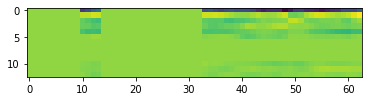

In [54]:
plt.imshow(audio[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


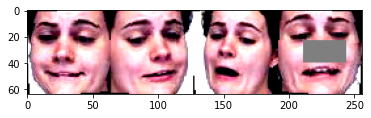

In [55]:
plt.imshow(video[0].permute(1, 2, 0)/2 + 0.5)

In [56]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))

5705 498 505
45 16 16


In [57]:
# audio model for our multimodal training
class BasicAudioRnnModel(torch.nn.Module):
  def __init__(self, input_size=128, hidden_size=512,num_layers=3, isBidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.linearIn = 2*hidden_size if isBidirectional else hidden_size
    self.rnn = torch.nn.GRU(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout = 0.3, #only for GRU and LSTM not for RNN
                            bidirectional=isBidirectional) #Test with unidirectional
    # self.linear = torch.nn.Linear(self.linearIn, num_classes) 
    self.out_shape = self.linearIn
  def forward(self, X):
    out, h = self.rnn(X)
    out_required = out[:, -1, :]
    # yhat = self.linear(out_required)
    return out_required

In [58]:
def get_padding_dims_same(in_height=64, in_width=64, filter_height=3, filter_width=3, strides=(None, 1, 1)):
    out_height = np.ceil(float(in_height) / float(strides[1]))
    out_width  = np.ceil(float(in_width) / float(strides[2]))

    if (in_height % strides[1] == 0): pad_along_height = max(filter_height - strides[1], 0)
    else: pad_along_height = max(filter_height - (in_height % strides[1]), 0)
    if (in_width % strides[2] == 0): pad_along_width = max(filter_width - strides[2], 0)
    else: pad_along_width = max(filter_width - (in_width % strides[2]), 0)
    pad_top = pad_along_height // 2; pad_bottom = pad_along_height - pad_top; pad_left = pad_along_width // 2
    pad_right = pad_along_width - pad_left
    return (pad_left + pad_right)//2, (pad_top + pad_bottom)//2
    return (pad_left, pad_right, pad_top, pad_bottom)

def get_output_size_convs(H, W, KW, KH, S, P):
    outputW = 1 + (W - KW + 2*P)//S
    outputH = 1 + (H - KH + 2*P)//S
    return outputW, outputH

In [59]:

class ResBlock(nn.Module):
    def __init__(self, W, H, params):
        super().__init__()
        self.params = params
        padding_dims1 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        self.conv1 = nn.Conv2d(params[0]['in_channels'], 
                               params[0]['out_channels'], 
                               kernel_size=params[0]['kernel_size'], 
                               stride=params[0]['stride'],
                               padding=padding_dims1)
        self.bn1 = nn.BatchNorm2d(params[0]['out_channels'])
        self.relu = nn.ReLU()
        
        padding_dims2 = get_padding_dims_same(W, H, 
                                              params[0]['kernel_size'], 
                                              params[0]['kernel_size'],
                                              (None, params[0]['stride'], params[0]['stride']))
        
        
        self.conv2 = nn.Conv2d(params[1]['in_channels'], 
                               params[1]['out_channels'], 
                               kernel_size=params[1]['kernel_size'], 
                               stride=params[1]['stride'],
                               padding=padding_dims2)
        self.bn2 = nn.BatchNorm2d(params[1]['out_channels'])
        if params[1]['channel_resizer']:
            self.channel_resizer = nn.Conv2d(params[0]['in_channels'], params[1]['out_channels'], kernel_size=1, stride=1)
        else:
            self.channel_resizer = nn.Identity()
        
    def forward(self, X):
        IN = X
#         print("0", X.shape)
        
        out = self.conv1(X)
#         print("1", out.shape)
        
        out = self.bn1(out)
#         print("2", out.shape)
        
        out = self.relu(out)
#         print("3", out.shape)
        
        out = self.conv2(out)
#         print("4", out.shape)
        IN = self.channel_resizer(IN)
#         print("5", IN.shape)
        
        out += IN
#         print("6", out.shape)
        return self.relu(out)

    
class NormalConvBlock(nn.Module):
    def __init__(self, W=64, H=64, params=None):
        super().__init__()
        self.params = params
        self.W = W
        self.H = H
        self.conv1 = nn.Conv2d(params['in_channels'], 
                               params['out_channels'],
                              kernel_size=params['kernel_size'],
                              stride=params['stride'])
        self.pool = nn.AvgPool2d(kernel_size=params['pool_kernel_size'], 
                                   stride=params['pool_stride'])
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.conv1(X)
        out = self.pool(out)
        out = self.relu(out)
        return out
    def get_output_size(self):
        w, h = get_output_size_convs(self.W, self.H, 
                                     self.params['kernel_size'], self.params['kernel_size'],
                                     self.params['stride'], 0)
        w, h = get_output_size_convs(w, h, 
                                     self.params['pool_kernel_size'], self.params['pool_kernel_size'],
                                     self.params['pool_stride'], 0)
        return self.params['out_channels'], w, h


class MyVideoSimpleModel(nn.Module):
    def __init__(self, W=64, H=64, hyperparameters=None, classes=4000):
        super().__init__()
        normal_params = hyperparameters['normal_params']
        resnet_params = hyperparameters['resnet_params']
        n_resnet_blocks = hyperparameters['n_resnet_blocks']
        
        layers = []
        
        w, h = W, H
        for i, n_params in enumerate(normal_params):
            layers.append(NormalConvBlock(w, h, n_params))
            c, w, h = layers[-1].get_output_size()
            print(c, w, h)
            
        print(f"Normal Inputs to ResBlocks: W: {w} H: {h}")
        
        for i in range(n_resnet_blocks):
            layers.append(ResBlock(W, H, resnet_params))
        
        self.net = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        
        self.out_shape = c*w*h
        
        # self.linear1 = nn.Linear(c*w*h, 1500)
        # self.tanh = nn.Tanh()
        # self.linear2 = nn.Linear(1500, classes)

    def forward(self, X, form='nlwc', return_bn=False):
        if form=='nlwc':
            X = X.permute(0, 3, 1, 2)
        out = self.net(X)
        out = self.flatten(out)
        # out = self.linear1(out)
        # out = self.tanh(out)
        # self.bottlenecks = out
        # out = self.linear2(out)
        # if return_bn: 
        #         return out, self.bottlenecks
        return out

In [60]:
class AudioVideoMMmodel4V2(nn.Module):
    def __init__(self, audio_hyperparameters, video_hyperparameters, classes=8, layer_emb=2000):
        super().__init__()
        self.audio_model = BasicAudioRnnModel(audio_hyperparameters['INPUT_SIZE'], 
                                              audio_hyperparameters['N_HIDDEN'], 
                                              audio_hyperparameters['NUM_LAYERS'],  
                                              audio_hyperparameters['IS_BIDIRECTIONAL'])
        
        self.video_model = MyVideoSimpleModel(hyperparameters=video_hyperparameters, W=256, H=64)

        self.in_shape = self.audio_model.out_shape + self.video_model.out_shape
        print(f"Audio Vector Size: {self.audio_model.out_shape}\nVideo Vector Shape: {self.video_model.out_shape}\nConcatenated: {self.in_shape}")
        self.linear_layer = torch.nn.Linear(self.in_shape, layer_emb)
        self.relu = torch.nn.ReLU()
        self.final_classifier = torch.nn.Linear(layer_emb, classes)
    def forward(self, audio, video, verbose=False):
      audio_out = self.audio_model(audio)
      video_out = self.video_model(video, form='nclw')
      concatenated_vector = torch.cat([audio_out, video_out], dim=1)
      if verbose:
        print(f"Concatenated vector shape: {concatenated_vector.shape}")
      out = self.linear_layer(concatenated_vector)
      out = self.relu(out)
      out = self.final_classifier(out)
      return out

In [73]:
# hyperparameters of my model for easy versioning is stored in a dictionary and later into a yaml file. 

# video model
normal_params = [{'in_channels':3, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'pool_kernel_size':2, 'pool_stride':2}]

resnet_params = [{'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False},
                 {'in_channels':128, 'out_channels':128, 'kernel_size':3, 'stride':1, 'channel_resizer':False}]
n_resnet_blocks = 5

video_hyperparameters = {'normal_params':normal_params,
                   'resnet_params':resnet_params,
                   'n_resnet_blocks':n_resnet_blocks}

# audio hyperparameters
audio_hyperparameters = {
    'INPUT_SIZE': 13,
    'N_HIDDEN': 512,
    'NUM_LAYERS':3,
    'IS_BIDIRECTIONAL': True
}

full_hyperparameters = {'audio_hyperparameters': audio_hyperparameters, 
                        'video_hyperparameters': video_hyperparameters}        

In [74]:
# audio.shape, video.shape, label.shape
full_hyperparameters

{'audio_hyperparameters': {'INPUT_SIZE': 13,
  'IS_BIDIRECTIONAL': True,
  'NUM_LAYERS': 3,
  'N_HIDDEN': 512},
 'video_hyperparameters': {'n_resnet_blocks': 5,
  'normal_params': [{'in_channels': 3,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1},
   {'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'pool_kernel_size': 2,
    'pool_stride': 2,
    'stride': 1}],
  'resnet_params': [{'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1},
   {'channel_resizer': False,
    'in_channels': 128,
    'kernel_size': 3,
    'out_channels': 128,
    'stride': 1}]}}

In [75]:
DEVICE = 'cuda'

In [76]:
av_model_4 = AudioVideoMMmodel4V2(audio_hyperparameters, video_hyperparameters)
av_model_4.to(DEVICE)

128 127 31
128 62 14
128 30 6
128 14 2
Normal Inputs to ResBlocks: W: 14 H: 2
Audio Vector Size: 1024
Video Vector Shape: 3584
Concatenated: 4608


AudioVideoMMmodel4V2(
  (audio_model): BasicAudioRnnModel(
    (rnn): GRU(13, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  )
  (video_model): MyVideoSimpleModel(
    (net): Sequential(
      (0): NormalConvBlock(
        (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (1): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (2): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (3): NormalConvBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (relu): ReLU()
      )
      (4): ResBlock(
        (

In [77]:
# outs = av_model_3(audio.permute(0, 2, 1), video, verbose=True)

In [78]:
# outs.shape

In [79]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(av_model_4.parameters(), lr=0.001) #initial lr=0.01
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=2)

In [80]:
def get_accuracy(yhat, y):
  return (yhat.argmax(1)==y).float().mean()


def train_one_epoch_audiovideov3(model, dataset, criterion, optim, epoch):
  model.train()
  losses = []
  accus = []
  stime = time.time()
  pbar = tqdm(dataset)
  for i, batch in enumerate(pbar):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    optim.zero_grad()
    l = criterion(outs, labels.long())
    l.backward()
    optim.step()

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())

    accuracy_avg = sum(accus)/len(accus)
    loss_avg = sum(losses)/len(losses)
    pbar.set_description(f"Progress - Accu: {accuracy_avg:.3f}\tLoss: {loss_avg:.3f}")

  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'\n[TRAIN] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

@torch.no_grad()
def evaluate_model(model, dataset, criterion, epoch, subset='VALID'):
  model.eval()
  losses = []
  accus = []
  stime = time.time()
  for i, batch in enumerate(dataset):
    audiofeats = batch[0].to(DEVICE)
    videofeats = batch[1].to(DEVICE)
    labels = batch[2].flatten().to(DEVICE)

    outs = model(torch.permute(audiofeats, (0, 2, 1)), videofeats)

    l = criterion(outs, labels.long())

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())
  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[{subset:5}] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

In [81]:
# res = train_one_epoch_audiovideov3(av_model_3, train_dataloader, criterion, optim, epoch=2)

In [82]:
# res_dv = evaluate_model(av_model_3, dev_dataloader, criterion, epoch=1)

In [83]:
get_lr = lambda optim: optim.param_groups[0]['lr']

In [84]:
N_EPOCHS = 50
for epoch in range(1, N_EPOCHS + 1):
  # training the model for one epoch
  print(f"Starting Training epoch: {epoch}")
  train_loss_avg, train_accuracy_avg, train_time_total = train_one_epoch_audiovideov3(av_model_4, train_dataloader, criterion, optim, epoch)

  # evaluate the model one epoch
  dev_loss_avg, dev_accuracy_avg, dev_time_total = evaluate_model(av_model_4, dev_dataloader, criterion, epoch)
  test_loss_avg, test_accuracy_avg, test_time_total = evaluate_model(av_model_4, test_dataloader, criterion, epoch, 'TEST')
  # scheduler
  scheduler.step(dev_loss_avg)
  print(f"Learning rate at epoch: {epoch} is {get_lr(optim)}\n")

Starting Training epoch: 1


Progress - Accu: 0.275	Loss: 2.076: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 1	Accu: 0.2745386222998301	Loss: 2.0755880064434473	Time: 16.641 secs


[VALID] Epoch: 1	Accu: 0.310546875	Loss: 1.815947838127613	Time: 1.291 secs
[TEST ] Epoch: 1	Accu: 0.3394531235098839	Loss: 1.8372673988342285	Time: 1.247 secs
Learning rate at epoch: 1 is 0.001

Starting Training epoch: 2


Progress - Accu: 0.421	Loss: 1.517: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 2	Accu: 0.42137319246927896	Loss: 1.5170459032058716	Time: 16.614 secs


[VALID] Epoch: 2	Accu: 0.3537326389923692	Loss: 1.8214892968535423	Time: 1.235 secs
[TEST ] Epoch: 2	Accu: 0.3821093738079071	Loss: 1.932595245540142	Time: 1.240 secs
Learning rate at epoch: 2 is 0.001

Starting Training epoch: 3


Progress - Accu: 0.492	Loss: 1.332: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 3	Accu: 0.4917308787504832	Loss: 1.3322379642062716	Time: 16.618 secs


[VALID] Epoch: 3	Accu: 0.5421006940305233	Loss: 1.2362014688551426	Time: 1.253 secs
[TEST ] Epoch: 3	Accu: 0.5453124977648258	Loss: 1.2908402010798454	Time: 1.279 secs
Learning rate at epoch: 3 is 0.001

Starting Training epoch: 4


Progress - Accu: 0.548	Loss: 1.192: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 4	Accu: 0.5480736295382181	Loss: 1.1918228175905017	Time: 16.587 secs


[VALID] Epoch: 4	Accu: 0.6440972238779068	Loss: 0.942931804805994	Time: 1.233 secs
[TEST ] Epoch: 4	Accu: 0.6314843744039536	Loss: 1.063340075314045	Time: 1.301 secs
Learning rate at epoch: 4 is 0.001

Starting Training epoch: 5


Progress - Accu: 0.587	Loss: 1.100: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 5	Accu: 0.5870933214823405	Loss: 1.099550990263621	Time: 16.613 secs


[VALID] Epoch: 5	Accu: 0.6475694440305233	Loss: 0.933143425732851	Time: 1.301 secs
[TEST ] Epoch: 5	Accu: 0.6515624970197678	Loss: 1.0095260106027126	Time: 1.272 secs
Learning rate at epoch: 5 is 0.001

Starting Training epoch: 6


Progress - Accu: 0.637	Loss: 0.966: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 6	Accu: 0.6368792812029521	Loss: 0.965990404287974	Time: 16.710 secs


[VALID] Epoch: 6	Accu: 0.6701388880610466	Loss: 0.8786750063300133	Time: 1.250 secs
[TEST ] Epoch: 6	Accu: 0.6822656244039536	Loss: 0.8680526632815599	Time: 1.212 secs
Learning rate at epoch: 6 is 0.001

Starting Training epoch: 7


Progress - Accu: 0.660	Loss: 0.897: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 7	Accu: 0.6600099881490071	Loss: 0.8965235948562622	Time: 16.716 secs


[VALID] Epoch: 7	Accu: 0.7055121529847383	Loss: 0.8023895900696516	Time: 1.265 secs
[TEST ] Epoch: 7	Accu: 0.6964843720197678	Loss: 0.7735741306096315	Time: 1.282 secs
Learning rate at epoch: 7 is 0.001

Starting Training epoch: 8


Progress - Accu: 0.687	Loss: 0.836: 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


[TRAIN] Epoch: 8	Accu: 0.6866604831483629	Loss: 0.8357159786754185	Time: 16.536 secs


[VALID] Epoch: 8	Accu: 0.6896701380610466	Loss: 0.8482294138520956	Time: 1.284 secs
[TEST ] Epoch: 8	Accu: 0.6825781241059303	Loss: 0.8646418433636427	Time: 1.259 secs
Learning rate at epoch: 8 is 0.001

Starting Training epoch: 9


Progress - Accu: 0.708	Loss: 0.769: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 9	Accu: 0.7076698064804077	Loss: 0.7691911114586725	Time: 16.614 secs


[VALID] Epoch: 9	Accu: 0.7170138880610466	Loss: 0.7712957933545113	Time: 1.295 secs
[TEST ] Epoch: 9	Accu: 0.7213281244039536	Loss: 0.7228881847113371	Time: 1.245 secs
Learning rate at epoch: 9 is 0.001

Starting Training epoch: 10


Progress - Accu: 0.741	Loss: 0.683: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 10	Accu: 0.7409650868839688	Loss: 0.6833485987451341	Time: 16.655 secs


[VALID] Epoch: 10	Accu: 0.7335069440305233	Loss: 0.6985192131251097	Time: 1.301 secs
[TEST ] Epoch: 10	Accu: 0.7380468733608723	Loss: 0.786677380092442	Time: 1.211 secs
Learning rate at epoch: 10 is 0.001

Starting Training epoch: 11


Progress - Accu: 0.770	Loss: 0.608: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 11	Accu: 0.7700818114810519	Loss: 0.6076935489972433	Time: 16.738 secs


[VALID] Epoch: 11	Accu: 0.7931857630610466	Loss: 0.5773168858140707	Time: 1.278 secs
[TEST ] Epoch: 11	Accu: 0.7692968733608723	Loss: 0.6183922030031681	Time: 1.307 secs
Learning rate at epoch: 11 is 0.001

Starting Training epoch: 12


Progress - Accu: 0.794	Loss: 0.556: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 12	Accu: 0.7938308596611023	Loss: 0.5559939881165822	Time: 16.672 secs


[VALID] Epoch: 12	Accu: 0.7858072929084301	Loss: 0.6147112771868706	Time: 1.284 secs
[TEST ] Epoch: 12	Accu: 0.7692968733608723	Loss: 0.5957782901823521	Time: 1.243 secs
Learning rate at epoch: 12 is 0.001

Starting Training epoch: 13


Progress - Accu: 0.812	Loss: 0.517: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 13	Accu: 0.8124453001552158	Loss: 0.5166828446918064	Time: 16.690 secs


[VALID] Epoch: 13	Accu: 0.7289496529847383	Loss: 0.789621016010642	Time: 1.270 secs
[TEST ] Epoch: 13	Accu: 0.750078123062849	Loss: 0.6628824481740594	Time: 1.283 secs
Learning rate at epoch: 13 is 0.001

Starting Training epoch: 14


Progress - Accu: 0.804	Loss: 0.529: 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


[TRAIN] Epoch: 14	Accu: 0.8037243154313829	Loss: 0.5292291892899408	Time: 16.778 secs


[VALID] Epoch: 14	Accu: 0.7202690988779068	Loss: 0.8734253887087107	Time: 1.296 secs
[TEST ] Epoch: 14	Accu: 0.737187497317791	Loss: 0.7589551918208599	Time: 1.250 secs
Learning rate at epoch: 14 is 0.0005

Starting Training epoch: 15


Progress - Accu: 0.861	Loss: 0.389: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 15	Accu: 0.8611491627163357	Loss: 0.38868094152874416	Time: 16.673 secs


[VALID] Epoch: 15	Accu: 0.8463541679084301	Loss: 0.4762439951300621	Time: 1.266 secs
[TEST ] Epoch: 15	Accu: 0.8571874983608723	Loss: 0.40678093722090125	Time: 1.255 secs
Learning rate at epoch: 15 is 0.0005

Starting Training epoch: 16


Progress - Accu: 0.891	Loss: 0.305: 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]


[TRAIN] Epoch: 16	Accu: 0.891312309106191	Loss: 0.3051514271232817	Time: 16.520 secs


[VALID] Epoch: 16	Accu: 0.80859375	Loss: 0.5080449795350432	Time: 1.267 secs
[TEST ] Epoch: 16	Accu: 0.8474218733608723	Loss: 0.42509727412834764	Time: 1.303 secs
Learning rate at epoch: 16 is 0.0005

Starting Training epoch: 17


Progress - Accu: 0.885	Loss: 0.296: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 17	Accu: 0.8854570971594916	Loss: 0.2962715913852056	Time: 16.682 secs


[VALID] Epoch: 17	Accu: 0.8003472238779068	Loss: 0.708439708687365	Time: 1.300 secs
[TEST ] Epoch: 17	Accu: 0.801640622317791	Loss: 0.5405871742404997	Time: 1.267 secs
Learning rate at epoch: 17 is 0.0005

Starting Training epoch: 18


Progress - Accu: 0.906	Loss: 0.265: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 18	Accu: 0.9056816021601359	Loss: 0.2654454516039954	Time: 16.658 secs


[VALID] Epoch: 18	Accu: 0.8374565988779068	Loss: 0.41052426490932703	Time: 1.278 secs
[TEST ] Epoch: 18	Accu: 0.8412499986588955	Loss: 0.47324237041175365	Time: 1.307 secs
Learning rate at epoch: 18 is 0.0005

Starting Training epoch: 19


Progress - Accu: 0.909	Loss: 0.249: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 19	Accu: 0.9090230213271246	Loss: 0.24884546399116517	Time: 16.712 secs


[VALID] Epoch: 19	Accu: 0.8678385429084301	Loss: 0.38973562349565327	Time: 1.264 secs
[TEST ] Epoch: 19	Accu: 0.866093747317791	Loss: 0.35791437327861786	Time: 1.249 secs
Learning rate at epoch: 19 is 0.0005

Starting Training epoch: 20


Progress - Accu: 0.910	Loss: 0.239: 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


[TRAIN] Epoch: 20	Accu: 0.9104547182718913	Loss: 0.23851762943797641	Time: 16.773 secs


[VALID] Epoch: 20	Accu: 0.8428819440305233	Loss: 0.4891227139160037	Time: 1.265 secs
[TEST ] Epoch: 20	Accu: 0.848515622317791	Loss: 0.5184750631451607	Time: 1.270 secs
Learning rate at epoch: 20 is 0.0005

Starting Training epoch: 21


Progress - Accu: 0.916	Loss: 0.234: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 21	Accu: 0.9164906766679551	Loss: 0.23366807566748726	Time: 16.693 secs


[VALID] Epoch: 21	Accu: 0.8595920130610466	Loss: 0.44212703965604305	Time: 1.274 secs
[TEST ] Epoch: 21	Accu: 0.871953122317791	Loss: 0.49668667931109667	Time: 1.252 secs
Learning rate at epoch: 21 is 0.0005

Starting Training epoch: 22


Progress - Accu: 0.928	Loss: 0.198: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 22	Accu: 0.928165430492825	Loss: 0.1980718617637952	Time: 16.748 secs


[VALID] Epoch: 22	Accu: 0.8615451380610466	Loss: 0.4601666694507003	Time: 1.234 secs
[TEST ] Epoch: 22	Accu: 0.868046872317791	Loss: 0.41223634989000857	Time: 1.281 secs
Learning rate at epoch: 22 is 0.00025

Starting Training epoch: 23


Progress - Accu: 0.945	Loss: 0.161: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 23	Accu: 0.945440924167633	Loss: 0.16116869780752394	Time: 16.736 secs


[VALID] Epoch: 23	Accu: 0.8736979179084301	Loss: 0.38570835441350937	Time: 1.254 secs
[TEST ] Epoch: 23	Accu: 0.889531247317791	Loss: 0.383363468805328	Time: 1.297 secs
Learning rate at epoch: 23 is 0.00025

Starting Training epoch: 24


Progress - Accu: 0.955	Loss: 0.129: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 24	Accu: 0.955205954445733	Loss: 0.12905189676417245	Time: 16.636 secs


[VALID] Epoch: 24	Accu: 0.8791232630610466	Loss: 0.42262271349318326	Time: 1.251 secs
[TEST ] Epoch: 24	Accu: 0.8722656220197678	Loss: 0.40352764970157295	Time: 1.298 secs
Learning rate at epoch: 24 is 0.00025

Starting Training epoch: 25


Progress - Accu: 0.960	Loss: 0.118: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 25	Accu: 0.9595462322235108	Loss: 0.11794894892308447	Time: 16.651 secs


[VALID] Epoch: 25	Accu: 0.8717447929084301	Loss: 0.42938530538231134	Time: 1.279 secs
[TEST ] Epoch: 25	Accu: 0.8728124983608723	Loss: 0.3884678476024419	Time: 1.321 secs
Learning rate at epoch: 25 is 0.00025

Starting Training epoch: 26


Progress - Accu: 0.956	Loss: 0.126: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 26	Accu: 0.956464041603936	Loss: 0.1262376058432791	Time: 16.670 secs


[VALID] Epoch: 26	Accu: 0.8869357630610466	Loss: 0.40765230427496135	Time: 1.256 secs
[TEST ] Epoch: 26	Accu: 0.8664062470197678	Loss: 0.4381960569880903	Time: 1.275 secs
Learning rate at epoch: 26 is 0.000125

Starting Training epoch: 27


Progress - Accu: 0.966	Loss: 0.108: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 27	Accu: 0.965579813056522	Loss: 0.10792334468828307	Time: 16.724 secs


[VALID] Epoch: 27	Accu: 0.8888888880610466	Loss: 0.362767631188035	Time: 1.270 secs
[TEST ] Epoch: 27	Accu: 0.892578125	Loss: 0.4526810236275196	Time: 1.273 secs
Learning rate at epoch: 27 is 0.000125

Starting Training epoch: 28


Progress - Accu: 0.968	Loss: 0.097: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 28	Accu: 0.9676631463898553	Loss: 0.09700058036380343	Time: 16.683 secs


[VALID] Epoch: 28	Accu: 0.8927951380610466	Loss: 0.38034012797288597	Time: 1.279 secs
[TEST ] Epoch: 28	Accu: 0.8978906236588955	Loss: 0.3990976174827665	Time: 1.229 secs
Learning rate at epoch: 28 is 0.000125

Starting Training epoch: 29


Progress - Accu: 0.967	Loss: 0.100: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 29	Accu: 0.967142313056522	Loss: 0.10035195243027475	Time: 16.614 secs


[VALID] Epoch: 29	Accu: 0.8873697929084301	Loss: 0.3766285269521177	Time: 1.272 secs
[TEST ] Epoch: 29	Accu: 0.888671875	Loss: 0.4343663214240223	Time: 1.308 secs
Learning rate at epoch: 29 is 0.000125

Starting Training epoch: 30


Progress - Accu: 0.969	Loss: 0.090: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 30	Accu: 0.9689212322235108	Loss: 0.08984055212802357	Time: 16.683 secs


[VALID] Epoch: 30	Accu: 0.8869357630610466	Loss: 0.3928247330477461	Time: 1.249 secs
[TEST ] Epoch: 30	Accu: 0.8909374997019768	Loss: 0.3684398863115348	Time: 1.278 secs
Learning rate at epoch: 30 is 6.25e-05

Starting Training epoch: 31


Progress - Accu: 0.966	Loss: 0.099: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 31	Accu: 0.9657106161117553	Loss: 0.09894176936811871	Time: 16.756 secs


[VALID] Epoch: 31	Accu: 0.8927951380610466	Loss: 0.3849637962412089	Time: 1.280 secs
[TEST ] Epoch: 31	Accu: 0.91015625	Loss: 0.3761186172487214	Time: 1.282 secs
Learning rate at epoch: 31 is 6.25e-05

Starting Training epoch: 32


Progress - Accu: 0.973	Loss: 0.086: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 32	Accu: 0.9726550605561998	Loss: 0.0861859888666206	Time: 16.753 secs


[VALID] Epoch: 32	Accu: 0.8927951380610466	Loss: 0.3691266889218241	Time: 1.264 secs
[TEST ] Epoch: 32	Accu: 0.912109375	Loss: 0.359516074298881	Time: 1.257 secs
Learning rate at epoch: 32 is 6.25e-05

Starting Training epoch: 33


Progress - Accu: 0.973	Loss: 0.077: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 33	Accu: 0.9729594747225444	Loss: 0.07687677103612157	Time: 16.707 secs


[VALID] Epoch: 33	Accu: 0.8869357630610466	Loss: 0.3963425981346518	Time: 1.285 secs
[TEST ] Epoch: 33	Accu: 0.8978906236588955	Loss: 0.3652665847912431	Time: 1.278 secs
Learning rate at epoch: 33 is 3.125e-05

Starting Training epoch: 34


Progress - Accu: 0.977	Loss: 0.074: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 34	Accu: 0.9770833333333333	Loss: 0.07398433966769112	Time: 16.590 secs


[VALID] Epoch: 34	Accu: 0.8893229179084301	Loss: 0.36632696678861976	Time: 1.292 secs
[TEST ] Epoch: 34	Accu: 0.90625	Loss: 0.3658177121542394	Time: 1.257 secs
Learning rate at epoch: 34 is 3.125e-05

Starting Training epoch: 35


Progress - Accu: 0.980	Loss: 0.065: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 35	Accu: 0.9800347222222222	Loss: 0.06509566952784857	Time: 16.687 secs


[VALID] Epoch: 35	Accu: 0.9006076380610466	Loss: 0.3582868347875774	Time: 1.270 secs
[TEST ] Epoch: 35	Accu: 0.8939843736588955	Loss: 0.3747536930022761	Time: 1.330 secs
Learning rate at epoch: 35 is 3.125e-05

Starting Training epoch: 36


Progress - Accu: 0.979	Loss: 0.064: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 36	Accu: 0.9794258938895332	Loss: 0.06435914453532961	Time: 16.732 secs


[VALID] Epoch: 36	Accu: 0.8947482630610466	Loss: 0.36769781447947025	Time: 1.349 secs
[TEST ] Epoch: 36	Accu: 0.8998437486588955	Loss: 0.3788187797181308	Time: 1.282 secs
Learning rate at epoch: 36 is 3.125e-05

Starting Training epoch: 37


Progress - Accu: 0.980	Loss: 0.067: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 37	Accu: 0.9795566969447665	Loss: 0.0665772672328684	Time: 16.753 secs


[VALID] Epoch: 37	Accu: 0.8947482630610466	Loss: 0.3709836257621646	Time: 1.291 secs
[TEST ] Epoch: 37	Accu: 0.900390625	Loss: 0.37630189291667193	Time: 1.268 secs
Learning rate at epoch: 37 is 3.125e-05

Starting Training epoch: 38


Progress - Accu: 0.976	Loss: 0.069: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 38	Accu: 0.9757348749372694	Loss: 0.06860522950688998	Time: 16.643 secs


[VALID] Epoch: 38	Accu: 0.8927951380610466	Loss: 0.37758024618960917	Time: 1.279 secs
[TEST ] Epoch: 38	Accu: 0.897343747317791	Loss: 0.37717576732393354	Time: 1.284 secs
Learning rate at epoch: 38 is 1.5625e-05

Starting Training epoch: 39


Progress - Accu: 0.977	Loss: 0.072: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 39	Accu: 0.9769953383339776	Loss: 0.07158039584755897	Time: 16.641 secs


[VALID] Epoch: 39	Accu: 0.8947482630610466	Loss: 0.3658088785596192	Time: 1.247 secs
[TEST ] Epoch: 39	Accu: 0.893437497317791	Loss: 0.3781721922568977	Time: 1.265 secs
Learning rate at epoch: 39 is 1.5625e-05

Starting Training epoch: 40


Progress - Accu: 0.976	Loss: 0.071: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 40	Accu: 0.9760844747225443	Loss: 0.07123606084949441	Time: 16.619 secs


[VALID] Epoch: 40	Accu: 0.8912760429084301	Loss: 0.36512723681516945	Time: 1.315 secs
[TEST ] Epoch: 40	Accu: 0.9037499986588955	Loss: 0.3714876276208088	Time: 1.275 secs
Learning rate at epoch: 40 is 1.5625e-05

Starting Training epoch: 41


Progress - Accu: 0.978	Loss: 0.070: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 41	Accu: 0.9777777777777777	Loss: 0.06993800583812926	Time: 16.729 secs


[VALID] Epoch: 41	Accu: 0.8947482630610466	Loss: 0.36447464954108	Time: 1.296 secs
[TEST ] Epoch: 41	Accu: 0.9037499986588955	Loss: 0.380882297991775	Time: 1.258 secs
Learning rate at epoch: 41 is 7.8125e-06

Starting Training epoch: 42


Progress - Accu: 0.979	Loss: 0.066: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 42	Accu: 0.9788622525003221	Loss: 0.06573062559796704	Time: 16.695 secs


[VALID] Epoch: 42	Accu: 0.8947482630610466	Loss: 0.35153992706909776	Time: 1.272 secs
[TEST ] Epoch: 42	Accu: 0.9017968736588955	Loss: 0.3785667307674885	Time: 1.308 secs
Learning rate at epoch: 42 is 7.8125e-06

Starting Training epoch: 43


Progress - Accu: 0.981	Loss: 0.062: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 43	Accu: 0.9809455858336554	Loss: 0.06202934918304284	Time: 16.748 secs


[VALID] Epoch: 43	Accu: 0.9006076380610466	Loss: 0.35486177750863135	Time: 1.276 secs
[TEST ] Epoch: 43	Accu: 0.9017968736588955	Loss: 0.3690566524164751	Time: 1.280 secs
Learning rate at epoch: 43 is 7.8125e-06

Starting Training epoch: 44


Progress - Accu: 0.978	Loss: 0.071: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 44	Accu: 0.9783842272228664	Loss: 0.07073101848363876	Time: 16.672 secs


[VALID] Epoch: 44	Accu: 0.8927951380610466	Loss: 0.3512195248622447	Time: 1.255 secs
[TEST ] Epoch: 44	Accu: 0.9017968736588955	Loss: 0.3702791704563424	Time: 1.314 secs
Learning rate at epoch: 44 is 7.8125e-06

Starting Training epoch: 45


Progress - Accu: 0.979	Loss: 0.067: 100%|██████████| 45/45 [00:16<00:00,  2.70it/s]


[TRAIN] Epoch: 45	Accu: 0.9785578383339776	Loss: 0.0669353324919939	Time: 16.670 secs


[VALID] Epoch: 45	Accu: 0.8927951380610466	Loss: 0.35367165389470756	Time: 1.306 secs
[TEST ] Epoch: 45	Accu: 0.899296872317791	Loss: 0.3700737974140793	Time: 1.297 secs
Learning rate at epoch: 45 is 7.8125e-06

Starting Training epoch: 46


Progress - Accu: 0.979	Loss: 0.064: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 46	Accu: 0.9789026829931471	Loss: 0.06405922079251872	Time: 16.716 secs


[VALID] Epoch: 46	Accu: 0.8967013880610466	Loss: 0.3546983334235847	Time: 1.280 secs
[TEST ] Epoch: 46	Accu: 0.9017968736588955	Loss: 0.36768307868624106	Time: 1.325 secs
Learning rate at epoch: 46 is 7.8125e-06

Starting Training epoch: 47


Progress - Accu: 0.980	Loss: 0.061: 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


[TRAIN] Epoch: 47	Accu: 0.9804675605561998	Loss: 0.06102045579916901	Time: 16.793 secs


[VALID] Epoch: 47	Accu: 0.9006076380610466	Loss: 0.35177508904598653	Time: 1.302 secs
[TEST ] Epoch: 47	Accu: 0.9017968736588955	Loss: 0.3597683042753488	Time: 1.320 secs
Learning rate at epoch: 47 is 3.90625e-06

Starting Training epoch: 48


Progress - Accu: 0.978	Loss: 0.064: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 48	Accu: 0.9779490100012885	Loss: 0.0641145281907585	Time: 16.757 secs


[VALID] Epoch: 48	Accu: 0.8967013880610466	Loss: 0.3493361175060272	Time: 1.282 secs
[TEST ] Epoch: 48	Accu: 0.8998437486588955	Loss: 0.36555663868784904	Time: 1.350 secs
Learning rate at epoch: 48 is 3.90625e-06

Starting Training epoch: 49


Progress - Accu: 0.977	Loss: 0.069: 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]


[TRAIN] Epoch: 49	Accu: 0.9767361111111111	Loss: 0.06899404848615329	Time: 16.712 secs


[VALID] Epoch: 49	Accu: 0.8967013880610466	Loss: 0.35378452739678323	Time: 1.275 secs
[TEST ] Epoch: 49	Accu: 0.9017968736588955	Loss: 0.3724603583686985	Time: 1.262 secs
Learning rate at epoch: 49 is 3.90625e-06

Starting Training epoch: 50


Progress - Accu: 0.981	Loss: 0.059: 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]


[TRAIN] Epoch: 50	Accu: 0.9805983636114333	Loss: 0.05919180375834306	Time: 16.597 secs


[VALID] Epoch: 50	Accu: 0.8986545130610466	Loss: 0.3590941072907299	Time: 1.267 secs
[TEST ] Epoch: 50	Accu: 0.9017968736588955	Loss: 0.37010384525638074	Time: 1.287 secs
Learning rate at epoch: 50 is 3.90625e-06



In [1]:
# predictions anf confusion matrix

In [ ]:
test_loss_avg, test_accuracy_avg, test_time_total = evaluate_model(av_model_3, test_dataloader, criterion, epoch)
print(test_loss_avg, test_accuracy_avg, test_time_total)

[VALID] Epoch: 39	Accu: 0.8820312470197678	Loss: 0.37239392928313464	Time: 1.240 secs
0.37239392928313464 0.8820312470197678 1.2396812438964844


In [ ]:
# dev_avdata.DATAHANDLES[:30]

In [ ]:
# dev_avdata.DATAHANDLES[0]
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
tmp = torch.cat([train_transforms(dev_avdata.video_data[x]) for x in dev_avdata.DATAHANDLES[1]['video']], dim=2)

In [ ]:
tmp.shape# dev_avdata.DATAHANDLES[2]

torch.Size([3, 64, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


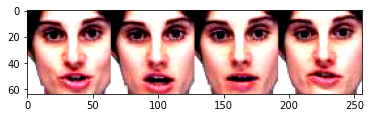

In [ ]:
plt.imshow(0.5 + tmp.permute(1, 2, 0)/2)